In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score,roc_curve
from joblib import Parallel, delayed
from sklearn.utils import resample
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 24})

import sys
sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

from misc import model_bar_colors, model_colors

%load_ext autoreload
%autoreload 2

In [2]:
data_dir='/lustre/groups/epigenereg01/workspace/projects/vale/mlm/motif_analysis/'

In [3]:
def calculate_auc(y_true, y_pred, weights, model_name, seed):
    np.random.seed(seed)
    n_samples = len(y_true)
    # bootstrap resampling according to weights
    bootstrap_idx = np.random.choice(range(n_samples),size=n_samples,replace=True,p=weights)    
    y_pred_resampled, y_true_resampled = y_pred[bootstrap_idx], y_true[bootstrap_idx]
    #y_pred_resampled, y_true_resampled = resample(y_pred, y_true, random_state=seed)
    auc = roc_auc_score(y_true_resampled, y_pred_resampled)
    return auc

def calculate_OR(y_true, y_pred, weights, model_name, seed):
    
    np.random.seed(seed)
    n_samples = len(y_true)
    # bootstrap resampling according to weights
    bootstrap_idx = np.random.choice(range(n_samples),size=n_samples,replace=True,p=weights)    
    
    y_pred_resampled, y_true_resampled = y_pred[bootstrap_idx], y_true[bootstrap_idx]
    
    model_pct_thr_bottom, model_pct_thr_top = prob_thr_OR.loc[model_name].values
    
    counts_func_top = y_true_resampled[y_pred_resampled>model_pct_thr_top].sum()
    counts_func_bottom = y_true_resampled[y_pred_resampled<model_pct_thr_bottom].sum()
    counts_nonfunc_top = (y_true_resampled[y_pred_resampled>model_pct_thr_top]==0).sum()
    counts_nonfunc_bottom = (y_true_resampled[y_pred_resampled<model_pct_thr_bottom]==0).sum()
    
    contig_table = [[counts_func_top,counts_nonfunc_top],[counts_func_bottom,counts_nonfunc_bottom]]
    
    fisher_test = scipy.stats.fisher_exact(contig_table)
    OR = fisher_test.statistic
    
    return OR
    
def bootstrap_score_parallel(y_true, y_pred, weights, model_name, scoring_func,
                             n_iterations=1000, ci_percentile=95):

    all_scores = Parallel(n_jobs=-1)(delayed(scoring_func)(y_true, y_pred, weights, model_name ,i) for i in range(n_iterations))

    # Compute the confidence interval
    ci_lower = np.percentile(all_scores, (100 - ci_percentile) / 2)
    ci_upper = np.percentile(all_scores, 100 - (100 - ci_percentile) / 2)
    
    score_mean = np.mean(all_scores)
    score_err = (ci_upper-ci_lower)/2
    
    return score_mean, score_err

def get_motif_weights_as_reference(cur_df, ref_df,keep_class_proportion = True):

    '''
    define weights for cur_df  that at boostraping 
    ensure the same k-mer distribution as in ref_df
    
    keep_class_proportion : keep the initial ratio of functional vs non-functional motifs in cur_df
    '''
    
    motif_counts_ref = ref_df.groupby('functional',observed=False).motif.value_counts()
    motif_counts_cur = cur_df.groupby('functional',observed=False).motif.value_counts()
    
    motif_weights = (motif_counts_ref/motif_counts_cur).fillna(0).rename('weight')
    
    weights_idx  = pd.MultiIndex.from_arrays([cur_df.functional,cur_df.motif])
    weights_cur = motif_weights.loc[weights_idx]

    if keep_class_proportion:
        weights_cur[False] = weights_cur[False]/weights_cur[False].sum()*motif_counts_cur[False].sum()
        weights_cur[True] = weights_cur[True]/weights_cur[True].sum()*motif_counts_cur[True].sum()

    weights_cur = weights_cur.values/weights_cur.sum()

    return weights_cur

def score(df, model_name, ref_df=None, n_bootstrap=1000):
    
    y_true,y_pred = df[['functional','score']].values.T
    y_true, y_pred = y_true.astype(int), y_pred.astype(float) 
    
    if ENSURE_KMER_DISTRIBUTION and ref_df is not None:
        weights = get_motif_weights_as_reference(df, ref_df)
    else:
        weights = None
        
    if metric=='AUC':
        scoring_func = calculate_auc
    elif metric == 'OR':
        scoring_func = calculate_OR
        
    score_mean, score_err = bootstrap_score_parallel(y_true, y_pred, weights, model_name, scoring_func, n_iterations=n_bootstrap)
    
    return (score_mean, score_err, y_true, y_pred)

In [4]:
#def get_mobility_groups(R, mobility_pct_bottom=10, mobility_pct_top=90):
#    
#    mobility_per_motif = conservation_df[conservation_df.functional].groupby('motif')[f'mobility_{R}'].mean()
#    
#    mobility_pct = (mobility_pct_bottom,100-mobility_pct_top)
#    mobility_thr = np.percentile(mobility_per_motif, mobility_pct)
#    #mobility_selection = ['bottom' if pct<50 else 'top' for pct in mobility_pct]
#    mobility_selection = ['bottom','top']
#    
#    mobility_categories = []
#        
#    for pct, thr, selection in zip(mobility_pct,mobility_thr,mobility_selection):
#        if selection=='bottom':
#            selected_motifs = mobility_per_motif[mobility_per_motif<=thr].index
#        else:
#            selected_motifs = mobility_per_motif[mobility_per_motif>thr].index
#        mobility_categories.append((pct,thr,selection,selected_motifs.tolist()))
#    
#    mobility_categories = pd.DataFrame(mobility_categories,columns=['mobility_pct','mobility_thr','how','motifs']).set_index('how')
#
#    return mobility_categories

In [5]:
def get_model_performance(model_name,mobility_pct_bottom=10,mobility_pct_top=90,n_bootstrap=1000):

    model_df = model_res_all[(model_res_all.model==model_name)&(~model_res_all.score.isna())]
    
    roc_curves[(model_name,'all',-1)] = score(model_df,model_name,ref_df=None,n_bootstrap=n_bootstrap)
    
    for R in tol_distances[1:]:
    
        #mobility_categories = get_mobility_groups(R, mobility_pct_bottom=mobility_pct_bottom, mobility_pct_top=mobility_pct_top)

        #motifs_top = mobility_categories[R].motifs.loc['top']
        #motifs_bottom = mobility_categories[R].motifs.loc['bottom']
        #mobility_top_df = model_df[model_df.motif.isin(motifs_top)]
        #mobility_bottom_df = model_df[model_df.motif.isin(motifs_bottom)]

        mobility_thr_bottom, mobility_thr_top = np.nanpercentile(conservation_df.loc[conservation_df.functional,f'mobility_{R}'],(mobility_pct_bottom,100-mobility_pct_top))
        mobility_top_df = model_df[(model_df[f'mobility_{R}']>=mobility_thr_top)|(model_df.functional==False)]
        mobility_bottom_df = model_df[(model_df[f'mobility_{R}']<=mobility_thr_bottom)|(model_df.functional==False)]

        roc_curves[(model_name,'top',R)] = score(mobility_top_df,model_name,ref_df=model_df,n_bootstrap=n_bootstrap)

        roc_curves[(model_name,'bottom',R)] = score(mobility_bottom_df,model_name,ref_df=model_df,n_bootstrap=n_bootstrap)

In [6]:
motif_len = 5
agg_strategy = 'MEAN' #MEAN or MAX
ENSURE_KMER_DISTRIBUTION = True #ensure the same k-mer frequency in the top and bottom mobility percentiles
metric = 'AUC' #OR or AUC
LM_scoring = 'ref' # 'ref', 'alt' or 'ref_vs_alt'

In [7]:
motifs_tsv = data_dir + f'../all_scores/motifs_k{motif_len}_agg_{agg_strategy}_zoo-al_hs.tsv.gz'

conservation_tsv = data_dir + f'conservation_k{motif_len}.tsv'

In [8]:
#functional score for all models
model_res_all = pd.read_csv(motifs_tsv,sep='\t')
model_res_all.rename(columns={'eCLIP_RBNS':'functional'},inplace=True)

In [9]:
#conservation for all motifs
conservation_df = pd.read_csv(conservation_tsv,sep='\t')

In [10]:
#utr_table = pd.read_csv(data_dir + '../UTR_coords/GRCh38_3_prime_UTR_clean.bed', sep='\t',
#                       usecols=[1,2,3], names=['utr_start','utr_end','seq_name']) #absolute coordinates of 3'UTR sequences
#
#utr_table['seq_len'] = utr_table.utr_end-utr_table.utr_start
#conservation_df = conservation_df.merge(utr_table[['seq_name','seq_len']])
#conservation_df = conservation_df[(conservation_df.seq_len-conservation_df.motif_start>=512)&(conservation_df.motif_start>=512)]

In [11]:
conservation_df.rename(columns={'seq_name':'UTR_ID','motif_start':'motif_start_UTR'},inplace=True)

In [12]:
#model_res_all = model_res_all.merge(conservation_df[['UTR_ID','motif_start_UTR','seq_len']],how='inner')

In [13]:
#add functional annotation to conservation_df
conservation_df = conservation_df.merge(model_res_all[['UTR_ID','motif','motif_start_UTR','functional']].drop_duplicates(), how='inner')

In [14]:
model_res_all['score'] = model_res_all.apply(lambda x: x.score_ref if x.model.startswith('PhyloP') or x.model=='Zoo-AL' else
                                                       x.score_alt if x.model.startswith('CADD') else
                                                       x[f'score_{LM_scoring}'], axis=1)

model_res_all = model_res_all[['UTR_ID','motif_start_UTR','motif','model','functional','score']]

In [15]:
# tol_distance==W//2
tol_distances = [int(x.split('_')[-1]) for x in conservation_df.columns if x.startswith('R_')]
tol_distances

[0, 5, 7, 12, 19, 31, 50, 79, 125, 199, 315, 500, 792, 1255, 1990, 3154, 5000]

In [16]:
#compute mobility for all W (R=W//2)
mobility_columns = []
for R in tol_distances[1:]:
    conservation_df[f'mobility_{R}'] = (conservation_df[f'R_{R}'] - conservation_df.R_0)/(conservation_df[f'R_{R}']+1)
    mobility_columns.append(f'mobility_{R}')

model_res_all = model_res_all.merge(conservation_df.loc[conservation_df.functional,['UTR_ID','motif_start_UTR']+mobility_columns], how='left')

In [17]:
#model_res_all.motif = model_res_all.motif.astype('category')
#
#model_res_all.functional = model_res_all.functional.astype('category')
#model_res_all.functional = model_res_all.functional.cat.set_categories([True,False], ordered=True)

In [18]:
mobility_pct_bottom = 10
mobility_pct_top = 10

In [19]:
#mobility_categories = {}
#
#for R in tol_distances[1:]: 
#    mobility_categories[R] = get_mobility_groups(R, mobility_pct_bottom=mobility_pct_bottom, mobility_pct_top=mobility_pct_top)

In [20]:
model_res_all.model.unique()

array(['DNABERT', 'DNABERT-3UTR', 'NT-MS-v2-100M', 'NTv2-100M-3UTR',
       'StateSpace', 'StateSpace-SA', 'StateSpace-DNA',
       'StateSpace-SA-DNA', 'StateSpace-HS', 'PhyloP-100way',
       'PhyloP-241way', 'CADD-1.7', 'Zoo-AL'], dtype=object)

In [21]:
prob_thr_OR = model_res_all.groupby('model').score.apply(lambda x:pd.Series(np.nanpercentile(x,(10,90)),index=['pct_bottom','pct_top']))

In [23]:
models = ['DNABERT', 'DNABERT-3UTR', 
          'NT-MS-v2-100M','NTv2-100M-3UTR',
          'StateSpace',  'StateSpace-DNA','StateSpace-HS',
          'PhyloP-100way', 'PhyloP-241way', 'CADD-1.7', 'Zoo-AL' ]

roc_curves = {}

for model_name in models:
    print(model_name)
    get_model_performance(model_name,
        mobility_pct_bottom=mobility_pct_bottom, mobility_pct_top=mobility_pct_top, n_bootstrap=100)

all_scores = [(model,how,auc,yerr,R) for (model,how,R),(auc,yerr,*_) in roc_curves.items()]
all_scores = pd.DataFrame(all_scores,columns=['model','how','score','yerr','R'])
all_scores['W'] = all_scores.R*2

DNABERT
DNABERT-3UTR
NT-MS-v2-100M
NTv2-100M-3UTR
StateSpace
StateSpace-DNA
StateSpace-HS
PhyloP-100way
PhyloP-241way
CADD-1.7
Zoo-AL


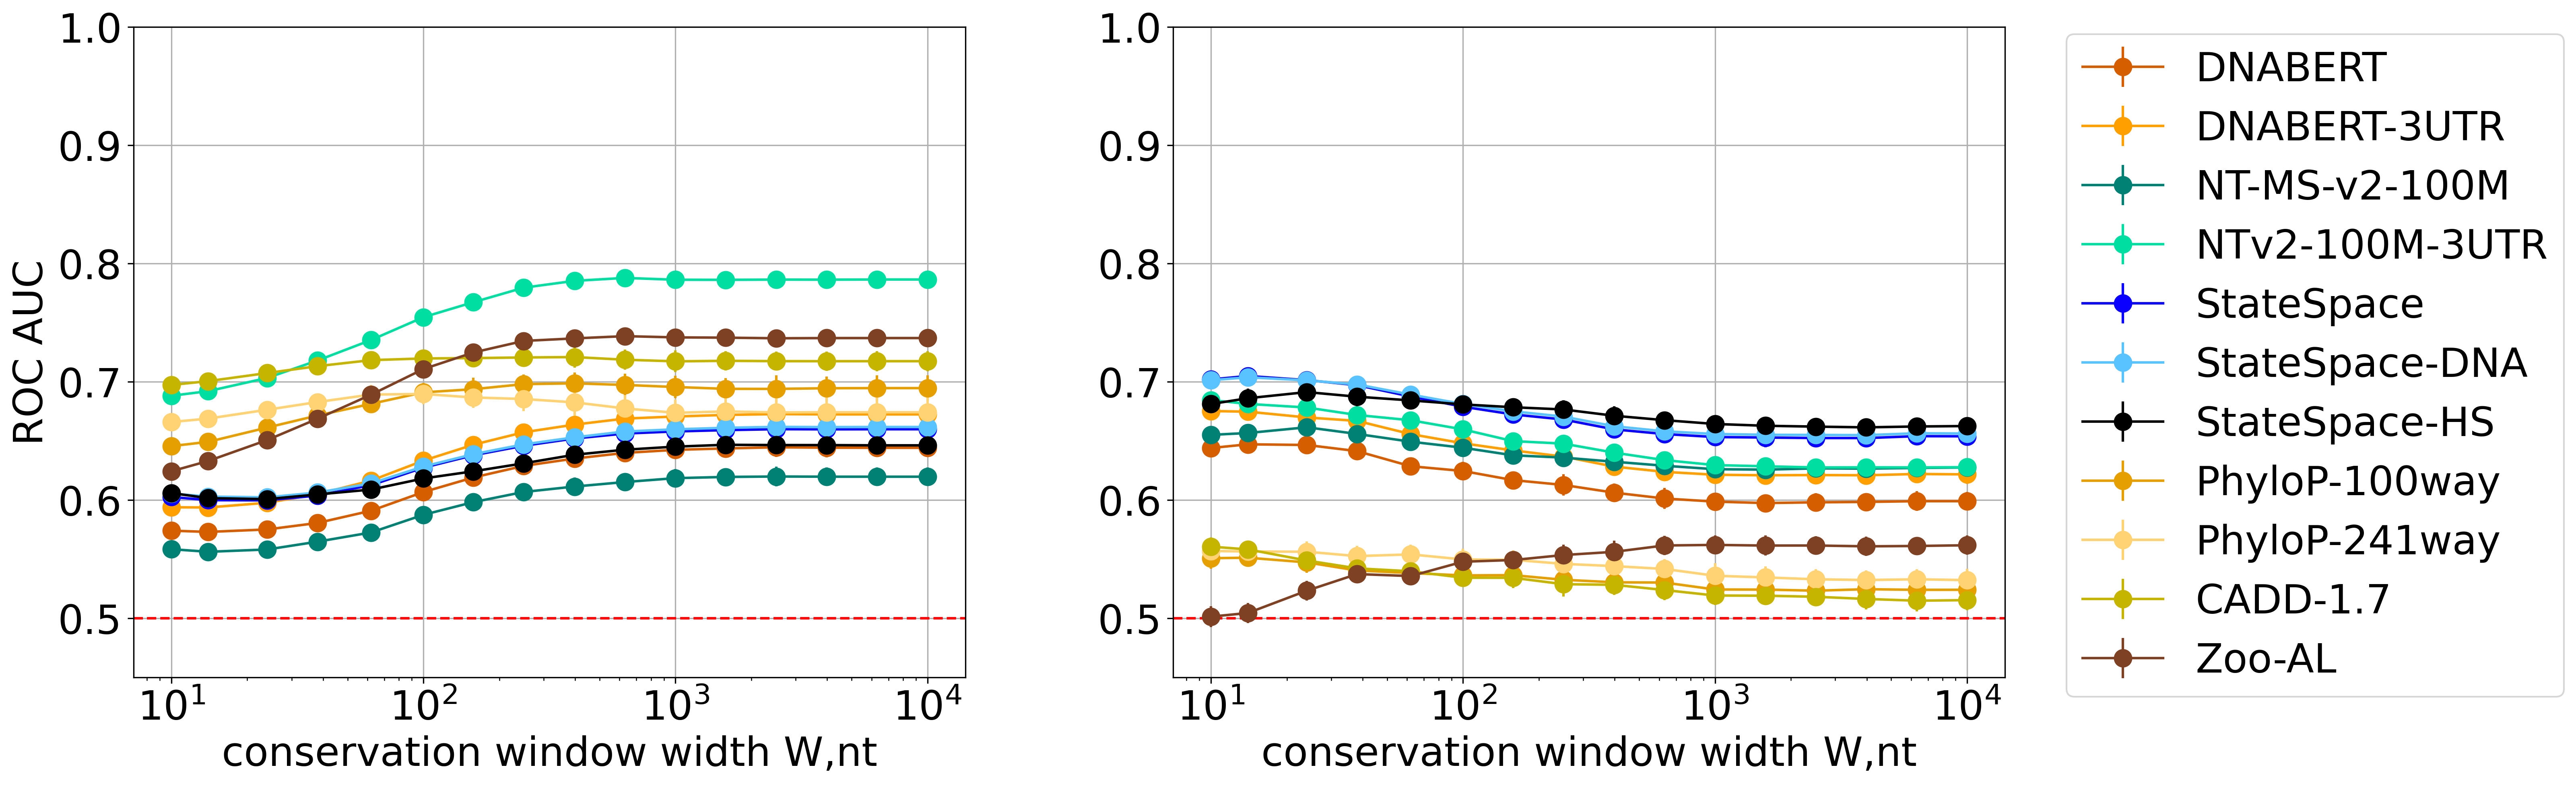

In [24]:
fig, axes = plt.subplots(1,2,figsize=(20,7),dpi=300)

for how,ax in zip(('bottom','top'),axes):
    for model in models:
        df = all_scores[(all_scores.model==model)&(all_scores.how==how)&(all_scores.W>0)]
        ax.errorbar(df.W,df.score,yerr=df.yerr,
        #ax.errorbar(df.W,df.OR,
                    color=model_colors[model],marker='.',markersize=20,label=model)

    ax.set_xscale('log')
    ax.grid(True)
    
    if metric=='AUC':
        ax.set_ylim([0.45,1])
        ax.axhline(0.5,color='r', linestyle='--')
    elif metric=='OR':
        ax.axhline(1,color='r', linestyle='--')
        
    ax.set_xlabel('conservation window width W,nt')
    
#    if how=='bottom':
#        ax.set_title(f'bottom {mobility_pct_bottom}% mobility')
#    else:
#        ax.set_title(f'top {mobility_pct_top}% mobility')

if metric=='AUC':
    axes[0].set_ylabel('ROC AUC')
elif metric=='OR':
    axes[0].set_ylabel('Odds ratio')
    
axes[1].legend(bbox_to_anchor=(1.05, 1.02),ncol=1,fontsize=24)

plt.subplots_adjust(wspace=0.25)

In [25]:
def get_cons_score_functional(mobility_df):

    if ENSURE_KMER_DISTRIBUTION:
        weights = get_motif_weights_as_reference(mobility_df, conservation_df)
        weights[mobility_df.functional==False] = 0 
        sample_idx = np.random.choice(range(len(mobility_df)),size=len(mobility_df),replace=True,p=weights/weights.sum())    
        return mobility_df.iloc[sample_idx][[f'R_{R}','R_0']].mean()
    else:
        return mobility_df.loc[mobility_df.functional,[f'R_{R}','R_0']].mean()

In [26]:
cons_score_summary = []

for R in tol_distances[1:]:
    mobility_thr_bottom, mobility_thr_top = np.nanpercentile(conservation_df.loc[conservation_df.functional,f'mobility_{R}'],(mobility_pct_bottom,100-mobility_pct_top))
    R_top, R_0_top = get_cons_score_functional(conservation_df[(conservation_df[f'mobility_{R}']>=mobility_thr_top)|(conservation_df.functional==False)])
    R_bottom, R_0_bottom = get_cons_score_functional(conservation_df[(conservation_df[f'mobility_{R}']<=mobility_thr_bottom)|(conservation_df.functional==False)])
    cons_score_summary.append((R*2,R_top,R_0_top,R_bottom,R_0_bottom))

In [27]:
R_0_nonfunc_all = conservation_df[conservation_df.functional==False].R_0.mean().astype(int)
R_0_func_all = conservation_df[conservation_df.functional==True].R_0.mean().astype(int)

print(R_0_nonfunc_all,R_0_func_all)

57 85


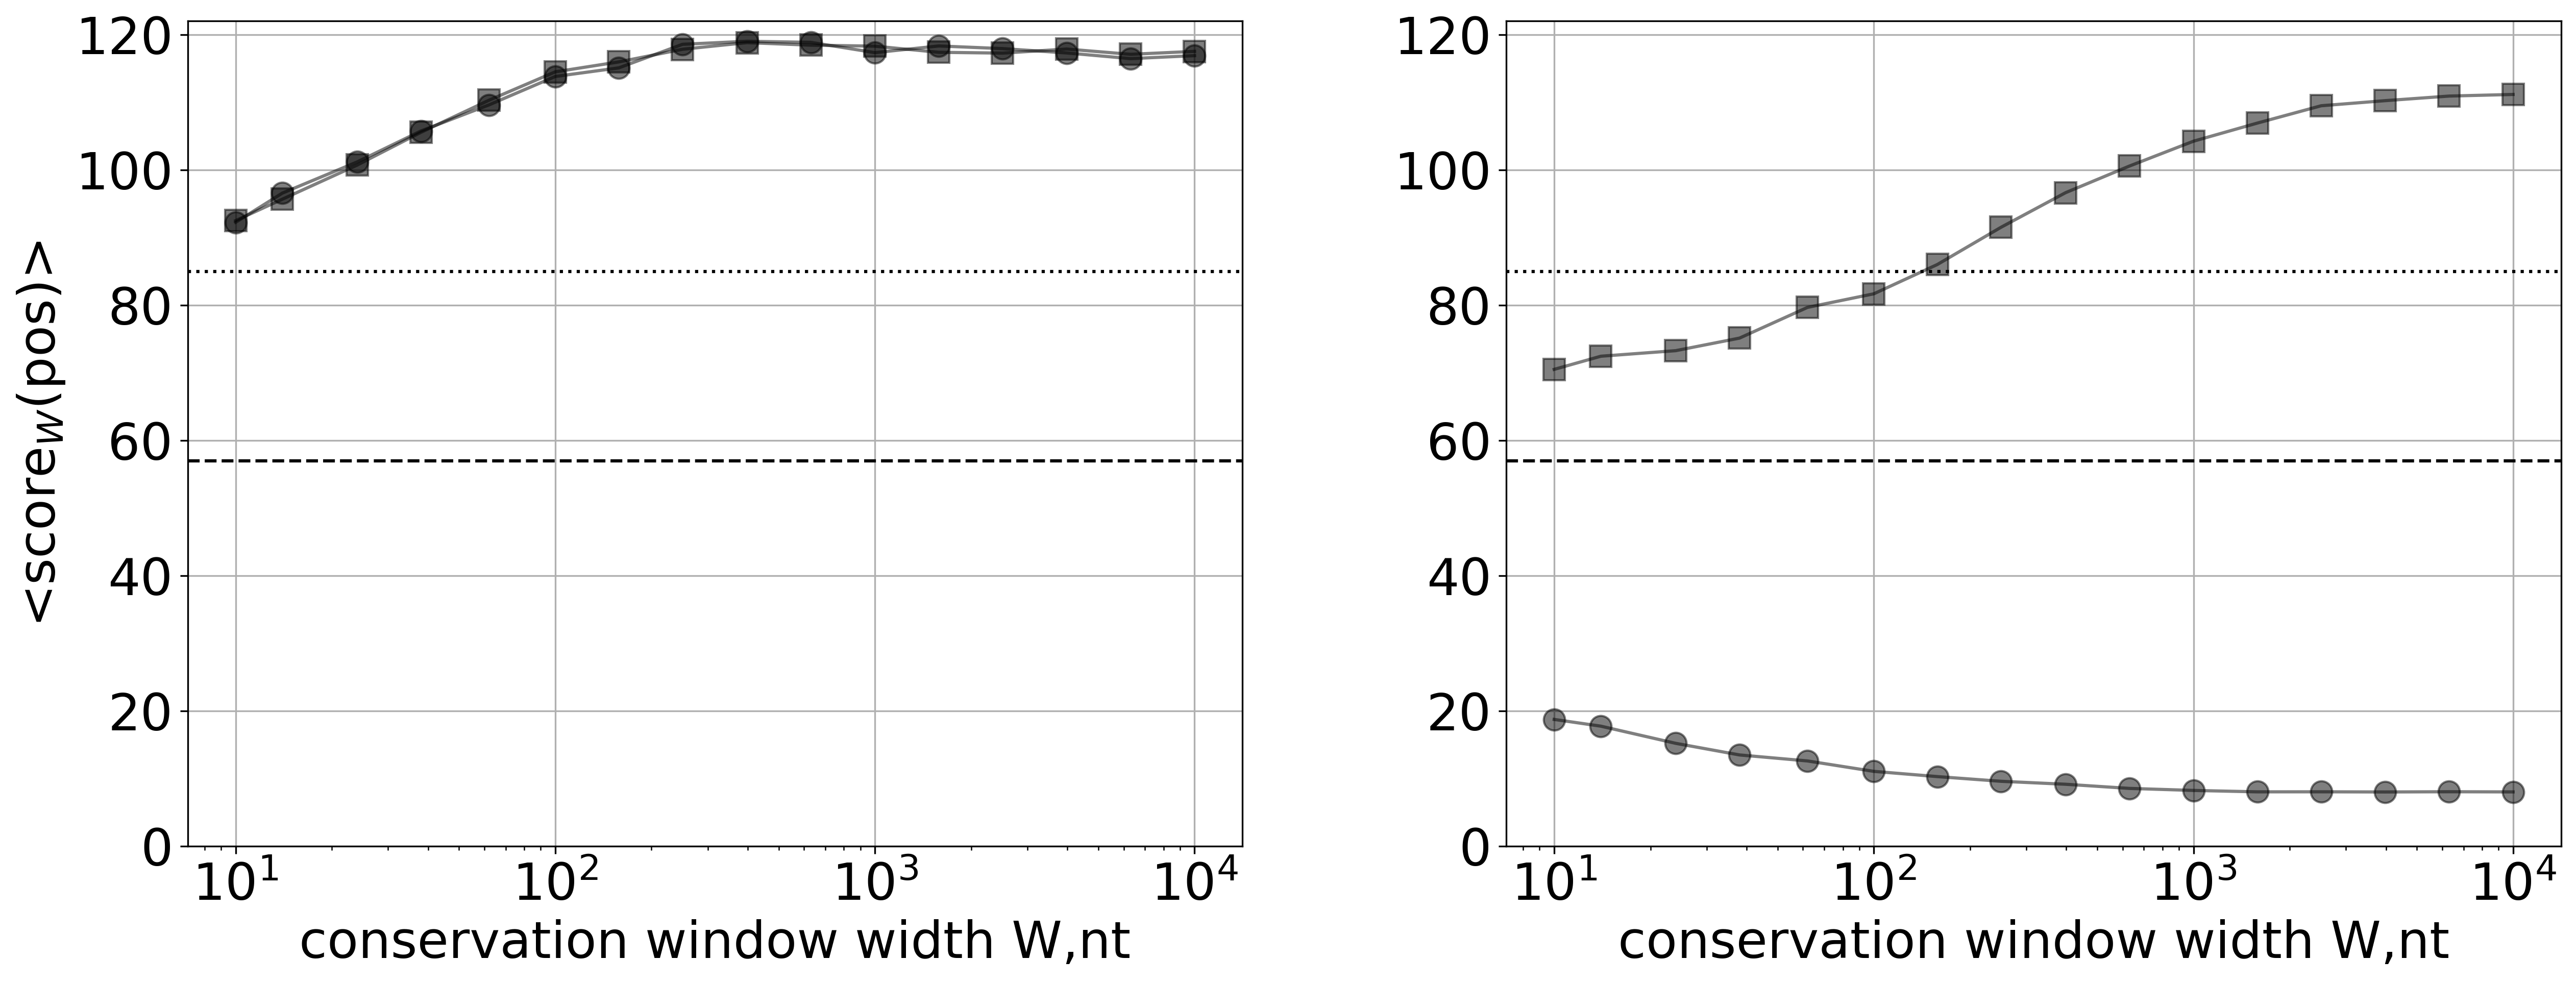

In [28]:
fig, axes = plt.subplots(1,2,figsize=(20,7),dpi=300)

W,R_top,R_0_top,R_bottom,R_0_bottom = np.array(cons_score_summary).T

np.random.seed(42)
jitter = (np.random.rand(len(tol_distances)-1,)-0.5)*2

for ax_idx, ax in enumerate(axes):

    if ax_idx==0:
        ax.plot(W,R_0_bottom+jitter,marker='.',markersize=20,color='k',alpha=0.5)
        ax.plot(W,R_bottom,marker='s',markersize=10,color='k',alpha=0.5)

    else:
        ax.plot(W,R_0_top,marker='.',markersize=20,color='k',alpha=0.5)
        ax.plot(W,R_top,marker='s',markersize=10,color='k',alpha=0.5)

    ax.axhline(R_0_func_all,color='k', linestyle=':')
    ax.axhline(R_0_nonfunc_all,color='k', linestyle='--')

    ax.set_xscale('log')
    ax.grid(True)
    ax.set_ylim([0,122])
    ax.set_xlabel('conservation window width W,nt')
    #ax.legend(loc='center right')

axes[0].set_ylabel('<score$_{W}$(pos)>')

plt.subplots_adjust(wspace=0.25)

In [29]:
W=1000

Text(0.5, 0, 'mobility')

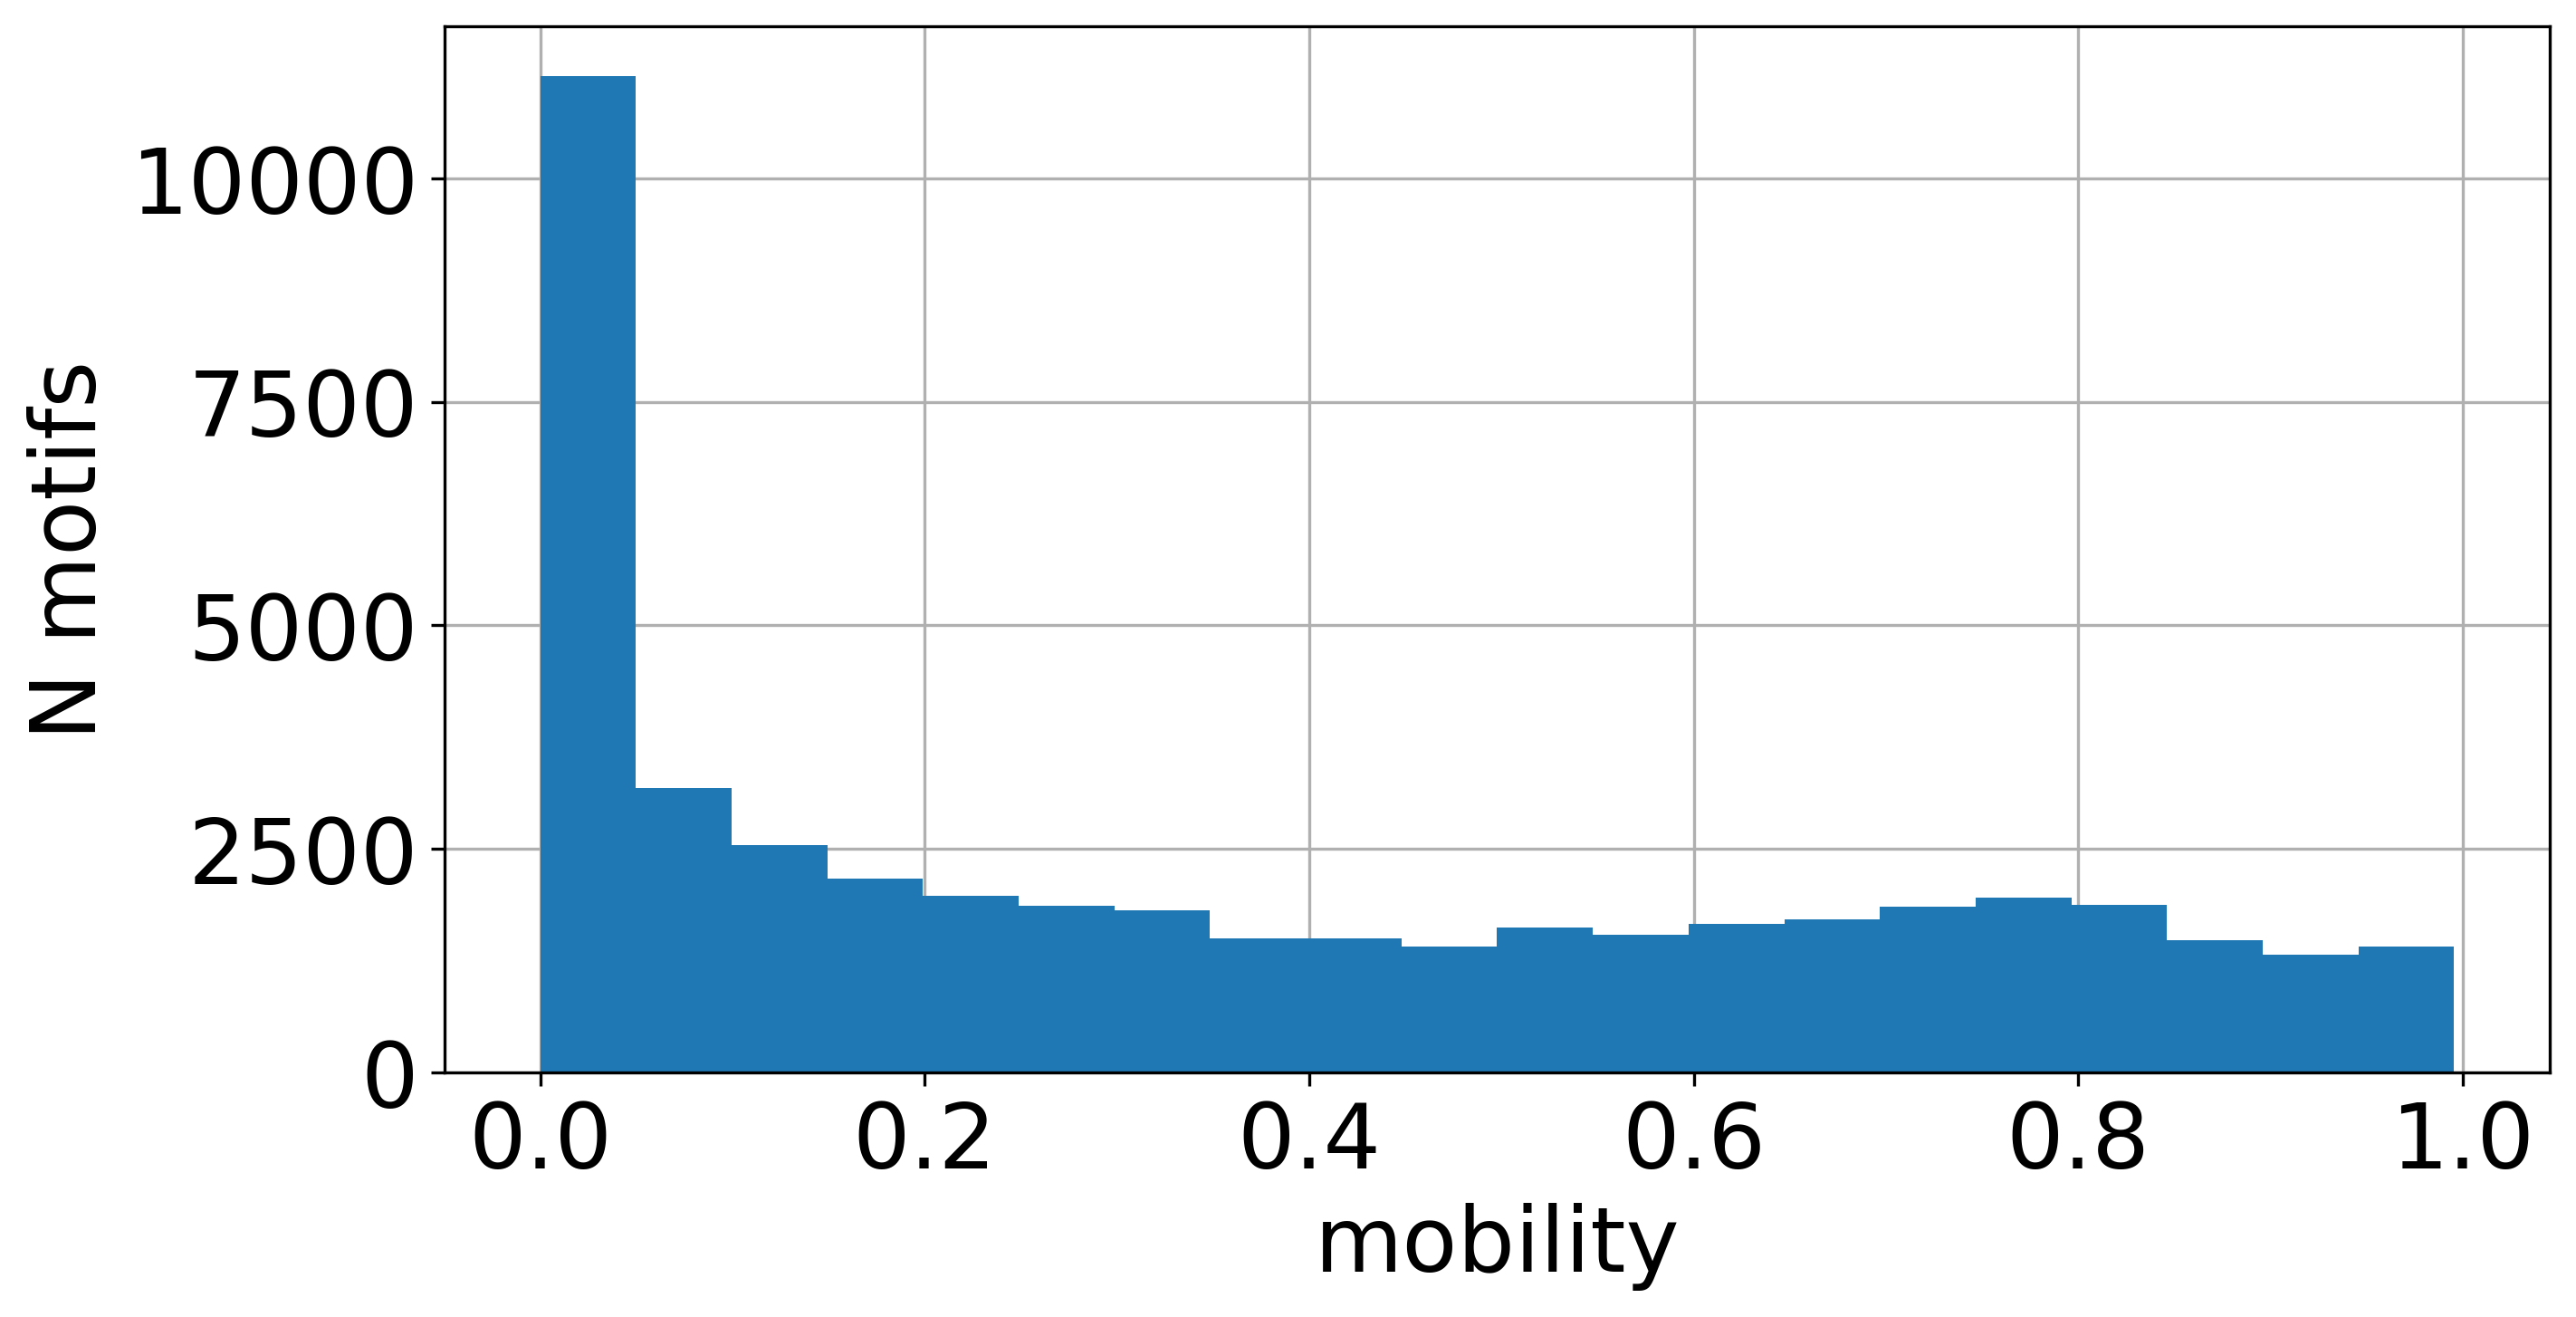

In [30]:
fig, ax = plt.subplots(dpi=300,figsize=(10,5))

mobility = conservation_df[conservation_df.functional==True][f'mobility_{W//2}']
        
mobility.hist(ax=ax,bins=20)

mobility_pct = (mobility_pct_bottom,100-mobility_pct_top)
mobility_thr = np.percentile(mobility, mobility_pct)
        
#ax.axvline(mobility_thr[0],color='k',linestyle='--')
#ax.axvline(mobility_thr[1],color='k',linestyle='--')

ax.grid(True)
ax.set_axisbelow(True)
ax.set_ylabel('N motifs')
ax.set_xlabel('mobility')
#ax.set_yscale('log')

In [35]:
W=1000

import sys
sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

import misc

df = all_scores.copy().set_index('model').loc[['DNABERT','DNABERT-3UTR','NT-MS-v2-100M','NTv2-100M-3UTR','StateSpace','StateSpace-DNA','StateSpace-HS',
                                             'PhyloP-100way','PhyloP-241way','CADD-1.7','Zoo-AL']]

df['score'] = df.apply(lambda x: (x.score,x.yerr),axis=1 )

scores_all = df[df.how=='all'].score.rename('all motifs')
scores_bottom10 = df[(df.W==W)&(df.how=='bottom')].score.rename(f'bottom {mobility_pct_bottom}% mobility')
scores_top10 = df[(df.W==W)&(df.how=='top')].score.rename(f'top {mobility_pct_top}% mobility')

summary_df = pd.concat([scores_all,scores_bottom10,scores_top10],axis=1)

best_models = summary_df.apply(misc.get_best_models).to_dict()

if metric=='AUC':
    summary_df_ = summary_df.map(lambda x: f'{x[0]:.3f}±{x[1]:.3f}')
elif metric=='OR':
    summary_df_ = summary_df.map(lambda x: f'{x[0]:.2f}±{x[1]:.2f}')

summary_df_.style.apply(lambda x: misc.highlight_ns(x, best_models))

,all motifs,bottom 10% mobility,top 10% mobility
model,,,
DNABERT,0.596±0.004,0.642±0.006,0.599±0.007
DNABERT-3UTR,0.628±0.004,0.671±0.006,0.621±0.008
NT-MS-v2-100M,0.603±0.003,0.619±0.008,0.626±0.008
NTv2-100M-3UTR,0.703±0.003,0.786±0.006,0.630±0.006
StateSpace,0.648±0.004,0.658±0.006,0.653±0.007
StateSpace-DNA,0.649±0.004,0.660±0.006,0.656±0.007
StateSpace-HS,0.651±0.003,0.645±0.007,0.664±0.007
PhyloP-100way,0.621±0.003,0.696±0.010,0.524±0.009
PhyloP-241way,0.647±0.004,0.674±0.011,0.536±0.011


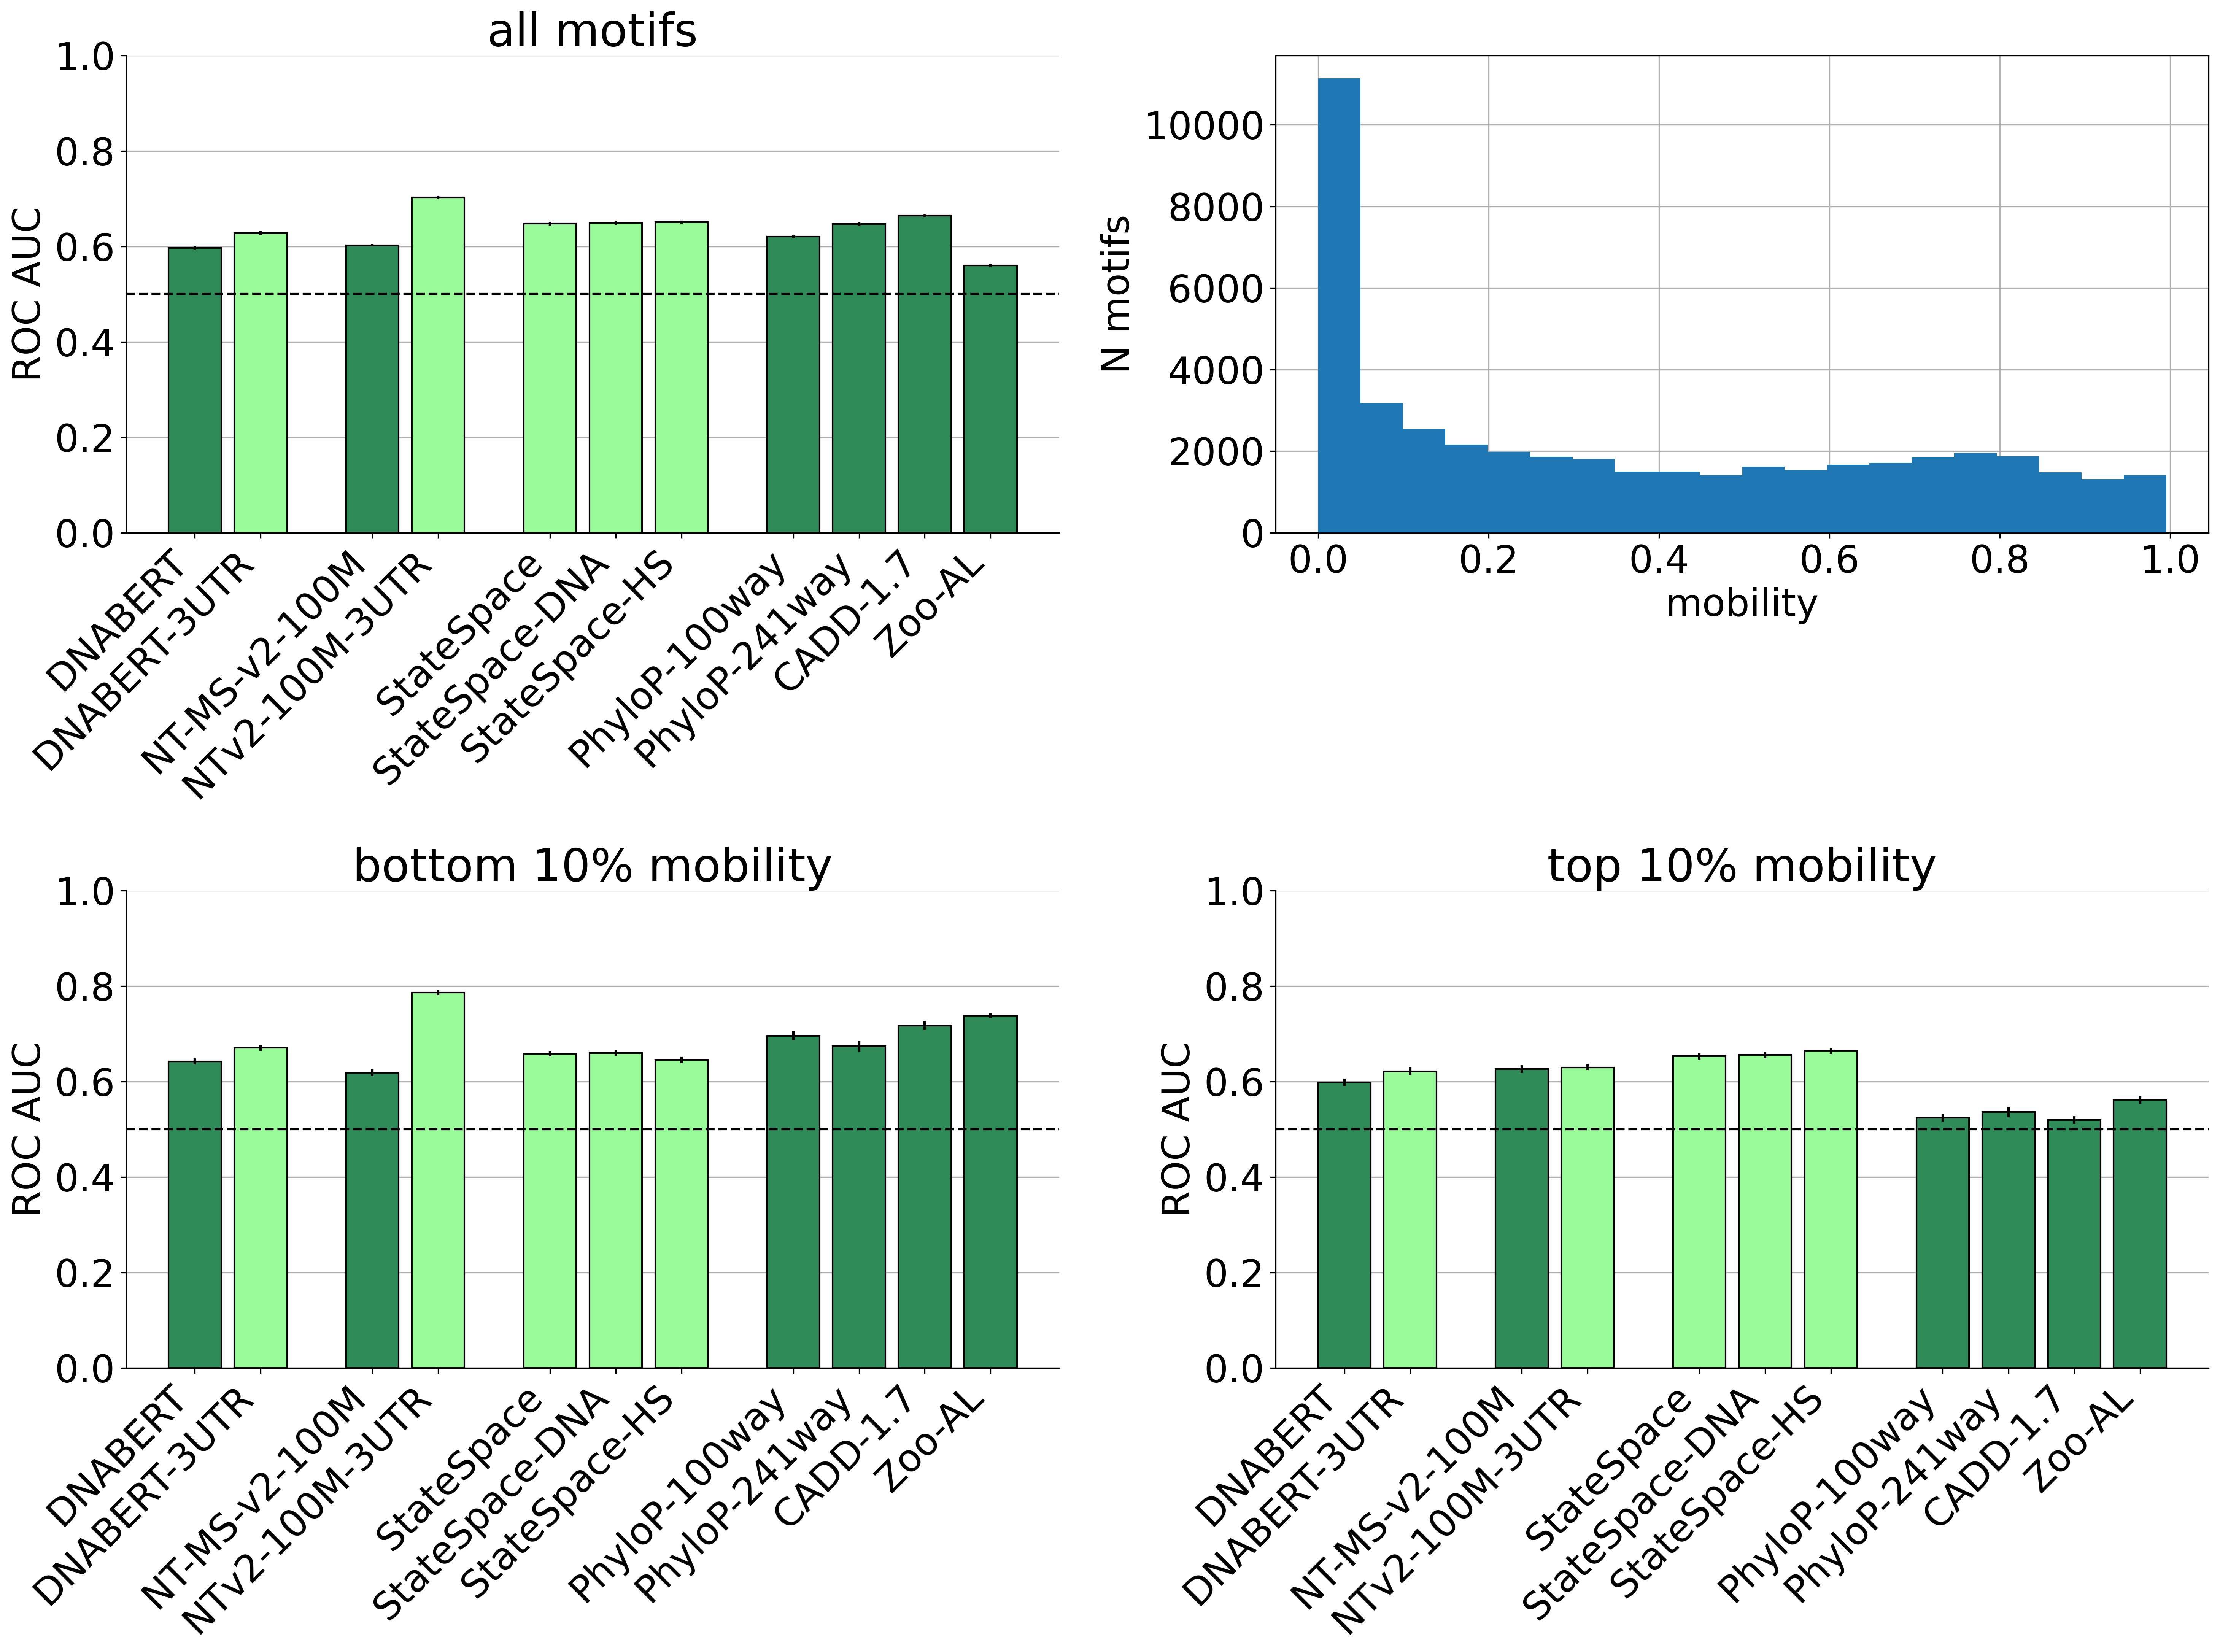

In [32]:
fig, axes = plt.subplots(2,2, dpi=300, figsize=(20,15))

axes = axes.flatten()

for ax_idx,ax in enumerate(axes):

    if ax_idx == 1:
            
        mobility = conservation_df[conservation_df.functional==True][f'mobility_{W//2}']
                
        mobility.hist(ax=ax,bins=20)
        
        mobility_pct = (mobility_pct_bottom,100-mobility_pct_top)
        mobility_thr = np.percentile(mobility, mobility_pct)

        #ax.axvline(mobility_thr[0],color='k',linestyle='--')
        #ax.axvline(mobility_thr[1],color='k',linestyle='--')

        ax.grid(True)
        ax.set_axisbelow(True)
        ax.set_ylabel('N motifs')
        ax.set_xlabel('mobility')
        #ax.set_xlim([0,8])

        continue

    elif ax_idx==2:
        odds_ratios = all_scores[(all_scores.how=='bottom')&(all_scores.W==W)].set_index('model')
        ax.set_title(f'bottom {mobility_pct_bottom}% mobility')
    elif ax_idx==3:
        odds_ratios = all_scores[(all_scores.how=='top')&(all_scores.W==W)].set_index('model')
        ax.set_title(f'top {mobility_pct_top}% mobility')
    else:
        odds_ratios = all_scores[all_scores.how=='all'].set_index('model')
        ax.set_title('all motifs')
        
    offset = 0

    xticks = []
    for idx, (model, row) in enumerate(odds_ratios.iterrows()):
        if model in ('DNABERT-2','NT-MS-v2-100M','StateSpace','DNABERT','PhyloP-100way'):
            offset+=0.7
        ax.bar(offset+idx, row.score, yerr=row.yerr, color=model_bar_colors[model], edgecolor='black')
        xticks.append(offset+idx)
        
    ax.set_xticks(xticks, odds_ratios.index, rotation=45, ha="right");
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    #ax.set_ylim([0,8])
    #if odds_ratios.OR.max()>50:
    #    ax.set_yscale('log')
    #if odds_ratios.OR.max()<4:
    #    ax.set_yticks(np.arange(0,4,0.5))

    if metric=='AUC':
        ax.axhline(0.5,color='k', linestyle='--')
        #ax.axhline(3.13,0,len(models),color='lightgray', linestyle='--')
        ax.set_ylim([0.,1])
        ax.set_ylabel('ROC AUC')
    elif metric=='OR':
        ax.axhline(1,color='k', linestyle='--')
        #ax.axhline(3.13,0,len(models),color='lightgray', linestyle='--')
        ax.set_yscale('log')
        ax.set_ylim([0,100])
        ax.set_ylabel('Odds ratio')
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()

In [33]:
best_score_list = all_scores[(all_scores.W==W)|(all_scores.how=='all')].groupby('how').apply(lambda x:x.sort_values(by='score',ascending=False).iloc[:3].set_index('model').score)

/tmp/ipykernel_1110291/3676354335.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_score_list = all_scores[(all_scores.W==W)|(all_scores.how=='all')].groupby('how').apply(lambda x:x.sort_values(by='score',ascending=False).iloc[:3].set_index('model').score)


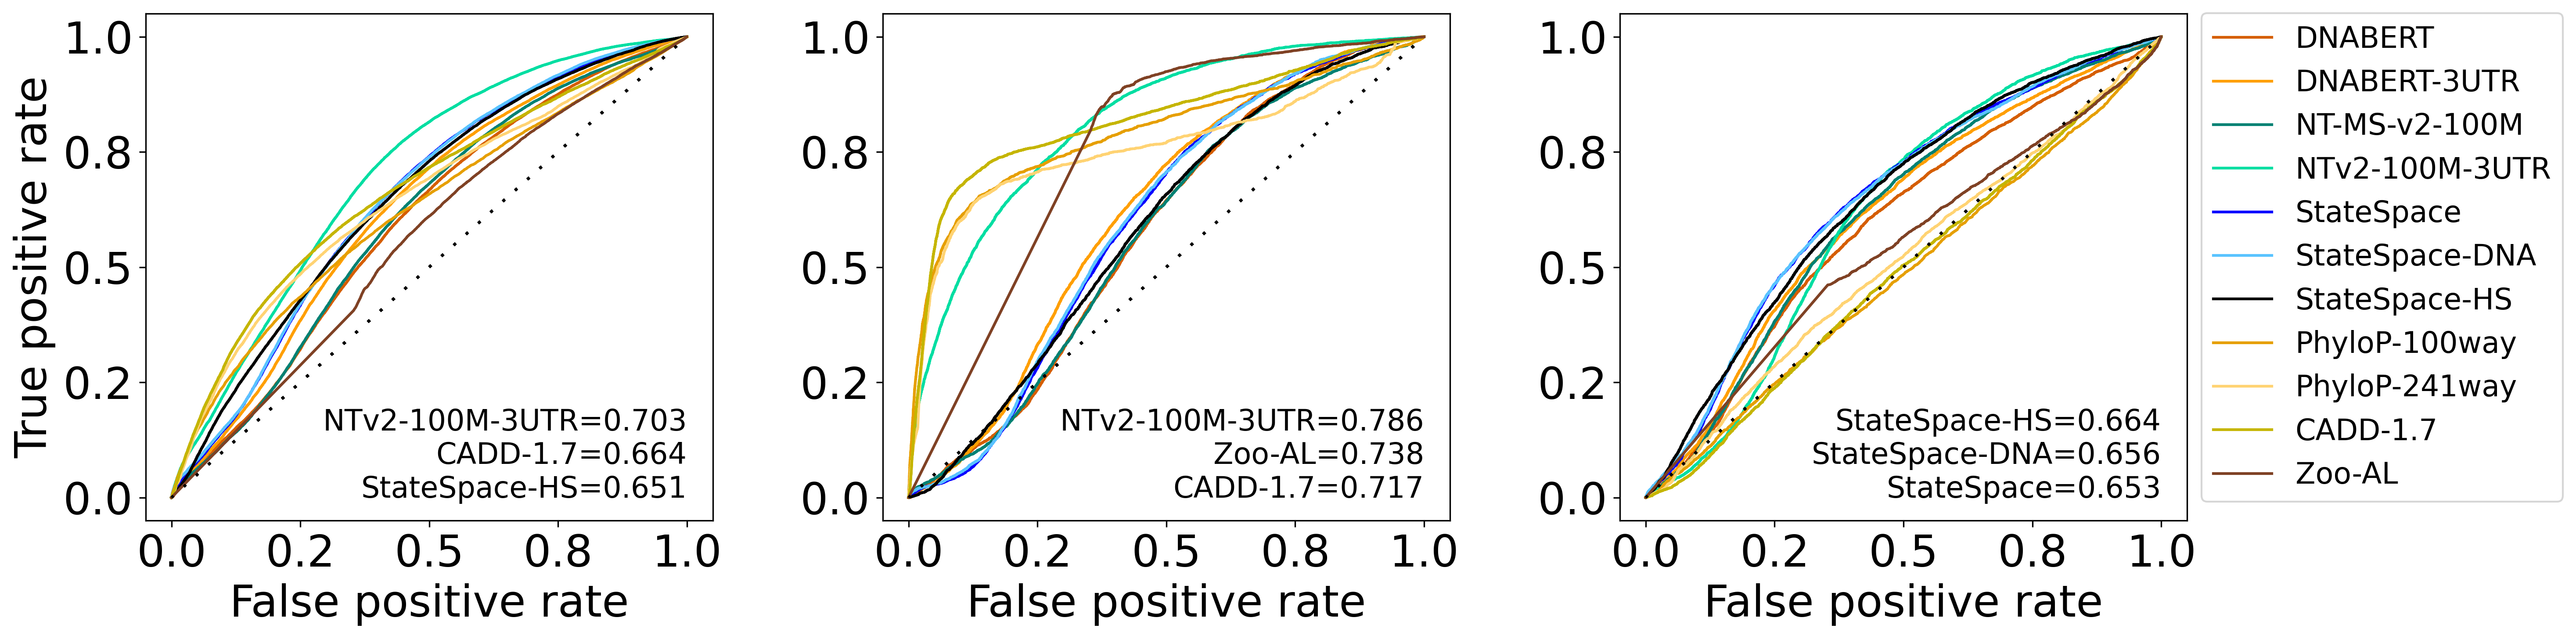

In [34]:
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(1,3, figsize=(20,5),dpi=300)

x = np.arange(0,1,0.01)

for ax_idx,ax in enumerate(axes):

    text=[]
    
    for model_name in models:
        if ax_idx == 0:
            auc, yerr, y_true, y_pred = roc_curves[(model_name,'all',-1)]
            how='all'
        elif ax_idx==1:
            auc, yerr, y_true, y_pred = roc_curves[(model_name,'bottom',W//2)]
            how='bottom'
        else:
            auc, yerr, y_true, y_pred = roc_curves[(model_name,'top',W//2)]
            how='top'

        fpr, tpr, _ = roc_curve(y_true,y_pred)
        #if auc<0.5:
        #    fpr, tpr = tpr, fpr
        ax.plot(fpr,tpr,color=model_colors[model_name],label=model_name)
        ax.plot(x,x, linestyle=(0,(1,5)), color='k')
        ax.set_xticks([0,0.25,0.5,0.75,1])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_yticks([0,0.25,0.5,0.75,1])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
    for model,auc in best_score_list.loc[how].items():
        text.append(f'{model}={auc:.3f}')
        
    ax.text(1,0,'\n'.join(text),horizontalalignment='right',fontsize=16)
    
    if ax_idx==0:
        ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')
    
    if ax_idx==2:
        ax.legend(bbox_to_anchor=(1., 1.03),ncol=1, fontsize=16)

#    if how=='all':
#        ax.set_title(f'all motifs')
#    elif how=='bottom':
#        ax.set_title(f'bottom {mobility_pct_bottom}% mobility')
#    else:
#        ax.set_title(f'top {mobility_pct_top}% mobility')

plt.subplots_adjust(wspace=0.3)